In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer
from fastshap import KernelExplainer
from lime.lime_tabular import LimeTabularExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../../data/seattle_sample_3k.csv')

In [3]:
data = gpd.GeoDataFrame(data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

In [4]:
data = data.to_crs(4326)

In [5]:
data['lon'] = data['geometry'].get_coordinates()['x']

In [6]:
data['lat'] = data['geometry'].get_coordinates()['y']

In [7]:
data['price'] = np.power(10, data['log_price']) / 10000

In [8]:
y = data.price
X = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'lon', 'lat']]
loc = data[['lon', 'lat']]

In [9]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(X, y, loc, train_size=0.8, random_state=42)

In [10]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [11]:
model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)

In [12]:
model.fit(X_train.values, y_train.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
model.score(X_test.values, y_test.values)

0.8678628554694814

In [14]:
feature_names = X_train.columns

In [15]:
lime_explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, verbose=False, mode='regression')

In [16]:
def lime_value_f(x):
    explanations = []
    for i in range(x.shape[0]):
        instance = x[i, :]
        res = lime_explainer.explain_instance(instance, model.predict, num_features=len(X_train.columns))
        explanation = [val[1] for val in res.as_list()]
        explanations.append(explanation)
    return np.array(explanations)

In [17]:
explainer = GeoConformalizedExplainer(prediction_f=model.predict,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      miscoverage_level=0.1,
                                      band_width=0.15,
                                      feature_names=feature_names,
                                      shap_value_f=lime_value_f)

In [18]:
results = explainer.uncertainty_aware_explain(x_test=X_test, coord_test=loc_test)

Explaining Variables


In [19]:
results.accuracy_summary()

Mean(|SHAP_value|)  Uncertainty        R2       RMSE    SHAP_Var  \
bathrooms             23.873218    24.362622  0.631491  14.247992  550.882880   
sqft_living           17.114139    21.909069  0.380524  10.636025  182.614088   
sqft_lot              11.503105    15.575680  0.529515   6.870382  100.326642   
grade                  8.124716    10.661539  0.482958   5.948112   68.427767   
condition              5.848737     7.518114  0.263203   4.407528   26.365885   
waterfront             4.106009     5.760746  0.366902   3.326254   17.475928   
view                   2.904809     4.448866  0.163251   2.770922    9.175999   
age                    2.151227     3.533261  0.074626   2.181635    5.143359   
lon                    1.426430     2.399099  0.030219   1.575227    2.558661   
lat                    0.697891     1.626574 -0.125868   0.962940    0.823590   

             Pred_SHAP_Var  
bathrooms       464.078424  
sqft_living      87.196847  
sqft_lot         49.786352  
grade            42.806299  
condition        14.450710  
waterfront        7.982347  
view              2.065125  
age               1.305094  
lon               0.578194  
lat               0.280409

In [20]:
results.accuracy_summary().to_csv('./SeattleHomeSale_accuracy_summary_lime.csv')

In [21]:
pred_results = results.result_geo
pred_results

bathrooms_shap  sqft_living_shap  sqft_lot_shap  grade_shap  \
0         21.670917        -20.144353     -11.592532    9.878325   
1        -14.869040        -14.160810      10.196763   -8.520592   
2        -14.133595        -13.351635     -11.559997    6.890671   
3         28.798645        -18.875747     -14.269957    8.279972   
4        -14.845148        -10.634031     -10.288708   -6.443881   
..              ...               ...            ...         ...   
295       28.088767        -14.623700       9.741445   -7.859442   
296      -24.187514        -19.069123     -14.109208  -11.321278   
297       28.650003        -28.280951      10.147921    8.307539   
298       29.114049        -23.451960     -14.476896  -10.693548   
299      -15.083747        -13.313825      -7.600930    7.435546   

     condition_shap  waterfront_shap  view_shap  age_shap  lon_shap  lat_shap  \
0         -7.351770        -6.530140   3.229982  1.648543 -1.647132 -1.556074   
1         -7.894454         4.220232  -3.126678  1.045449 -0.941464 -0.544395   
2         -6.517520         5.535170  -4.134470 -1.631196 -0.963872  0.001926   
3         -8.205220        -5.942098   2.376935 -2.002634 -0.926949 -0.542434   
4          3.125229        -2.719527   2.592377 -2.223450 -2.106050  1.769776   
..              ...              ...        ...       ...       ...       ...   
295       -7.358865        -6.952750  -2.534167  2.258995  2.228219 -1.000914   
296       -7.138719        -2.591040   2.533551  1.925990  0.687073  0.184319   
297        5.980911         4.394949   3.204603  3.200537 -0.678048 -0.209560   
298        6.360512         4.216554  -2.862763 -1.943321  1.807031  1.312024   
299       -5.272696         3.075372  -2.682727 -2.051002  1.669236 -0.073251   

     ...  lat_geo_uncertainty  lat_uncertainty  lat_upper_bound  \
0    ...             1.634983         1.626574         1.408654   
1    ...             1.634983         1.626574         1.780021   
2    ...             1.634983         1.626574         1.002589   
3    ...             1.634983         1.626574         0.721633   
4    ...             1.634983         1.626574         1.743677   
..   ...                  ...              ...              ...   
295  ...             1.713424         1.626574         1.841610   
296  ...             1.625640         1.626574         1.808901   
297  ...             1.634983         1.626574         1.756831   
298  ...             1.624179         1.626574         1.853795   
299  ...             1.634983         1.626574         0.782651   

     lat_lower_bound  lat_coverage_probability  lat_pred  lat_shap_abs  \
0          -1.861313                      0.92 -0.226330      1.556074   
1          -1.489946                      0.92  0.145037      0.544395   
2          -2.267378                      0.92 -0.632395      0.001926   
3          -2.548334                      0.92 -0.913350      0.542434   
4          -1.526290                      0.92  0.108693      1.769776   
..               ...                       ...       ...           ...   
295        -1.585238                      0.92  0.128186      1.000914   
296        -1.442379                      0.92  0.183261      0.184319   
297        -1.513136                      0.92  0.121847      0.209560   
298        -1.394563                      0.92  0.229616      1.312024   
299        -2.487316                      0.92 -0.852333      0.073251   

           x        y                     geometry  
0   -122.178  47.6948  POINT (-122.17800 47.69480)  
1   -122.364  47.5030  POINT (-122.36400 47.50300)  
2   -122.360  47.5659  POINT (-122.36000 47.56590)  
3   -122.304  47.5880  POINT (-122.30400 47.58800)  
4   -122.288  47.5412  POINT (-122.28800 47.54120)  
..       ...      ...                          ...  
295 -122.127  47.6557  POINT (-122.12700 47.65570)  
296 -122.242  47.2630  POINT (-122.24200 47.26300)  
297 -122.405  47.6420  POINT (-122.40500 47.

In [22]:
pred_results.to_csv('./seattle_house_results_lime.csv')

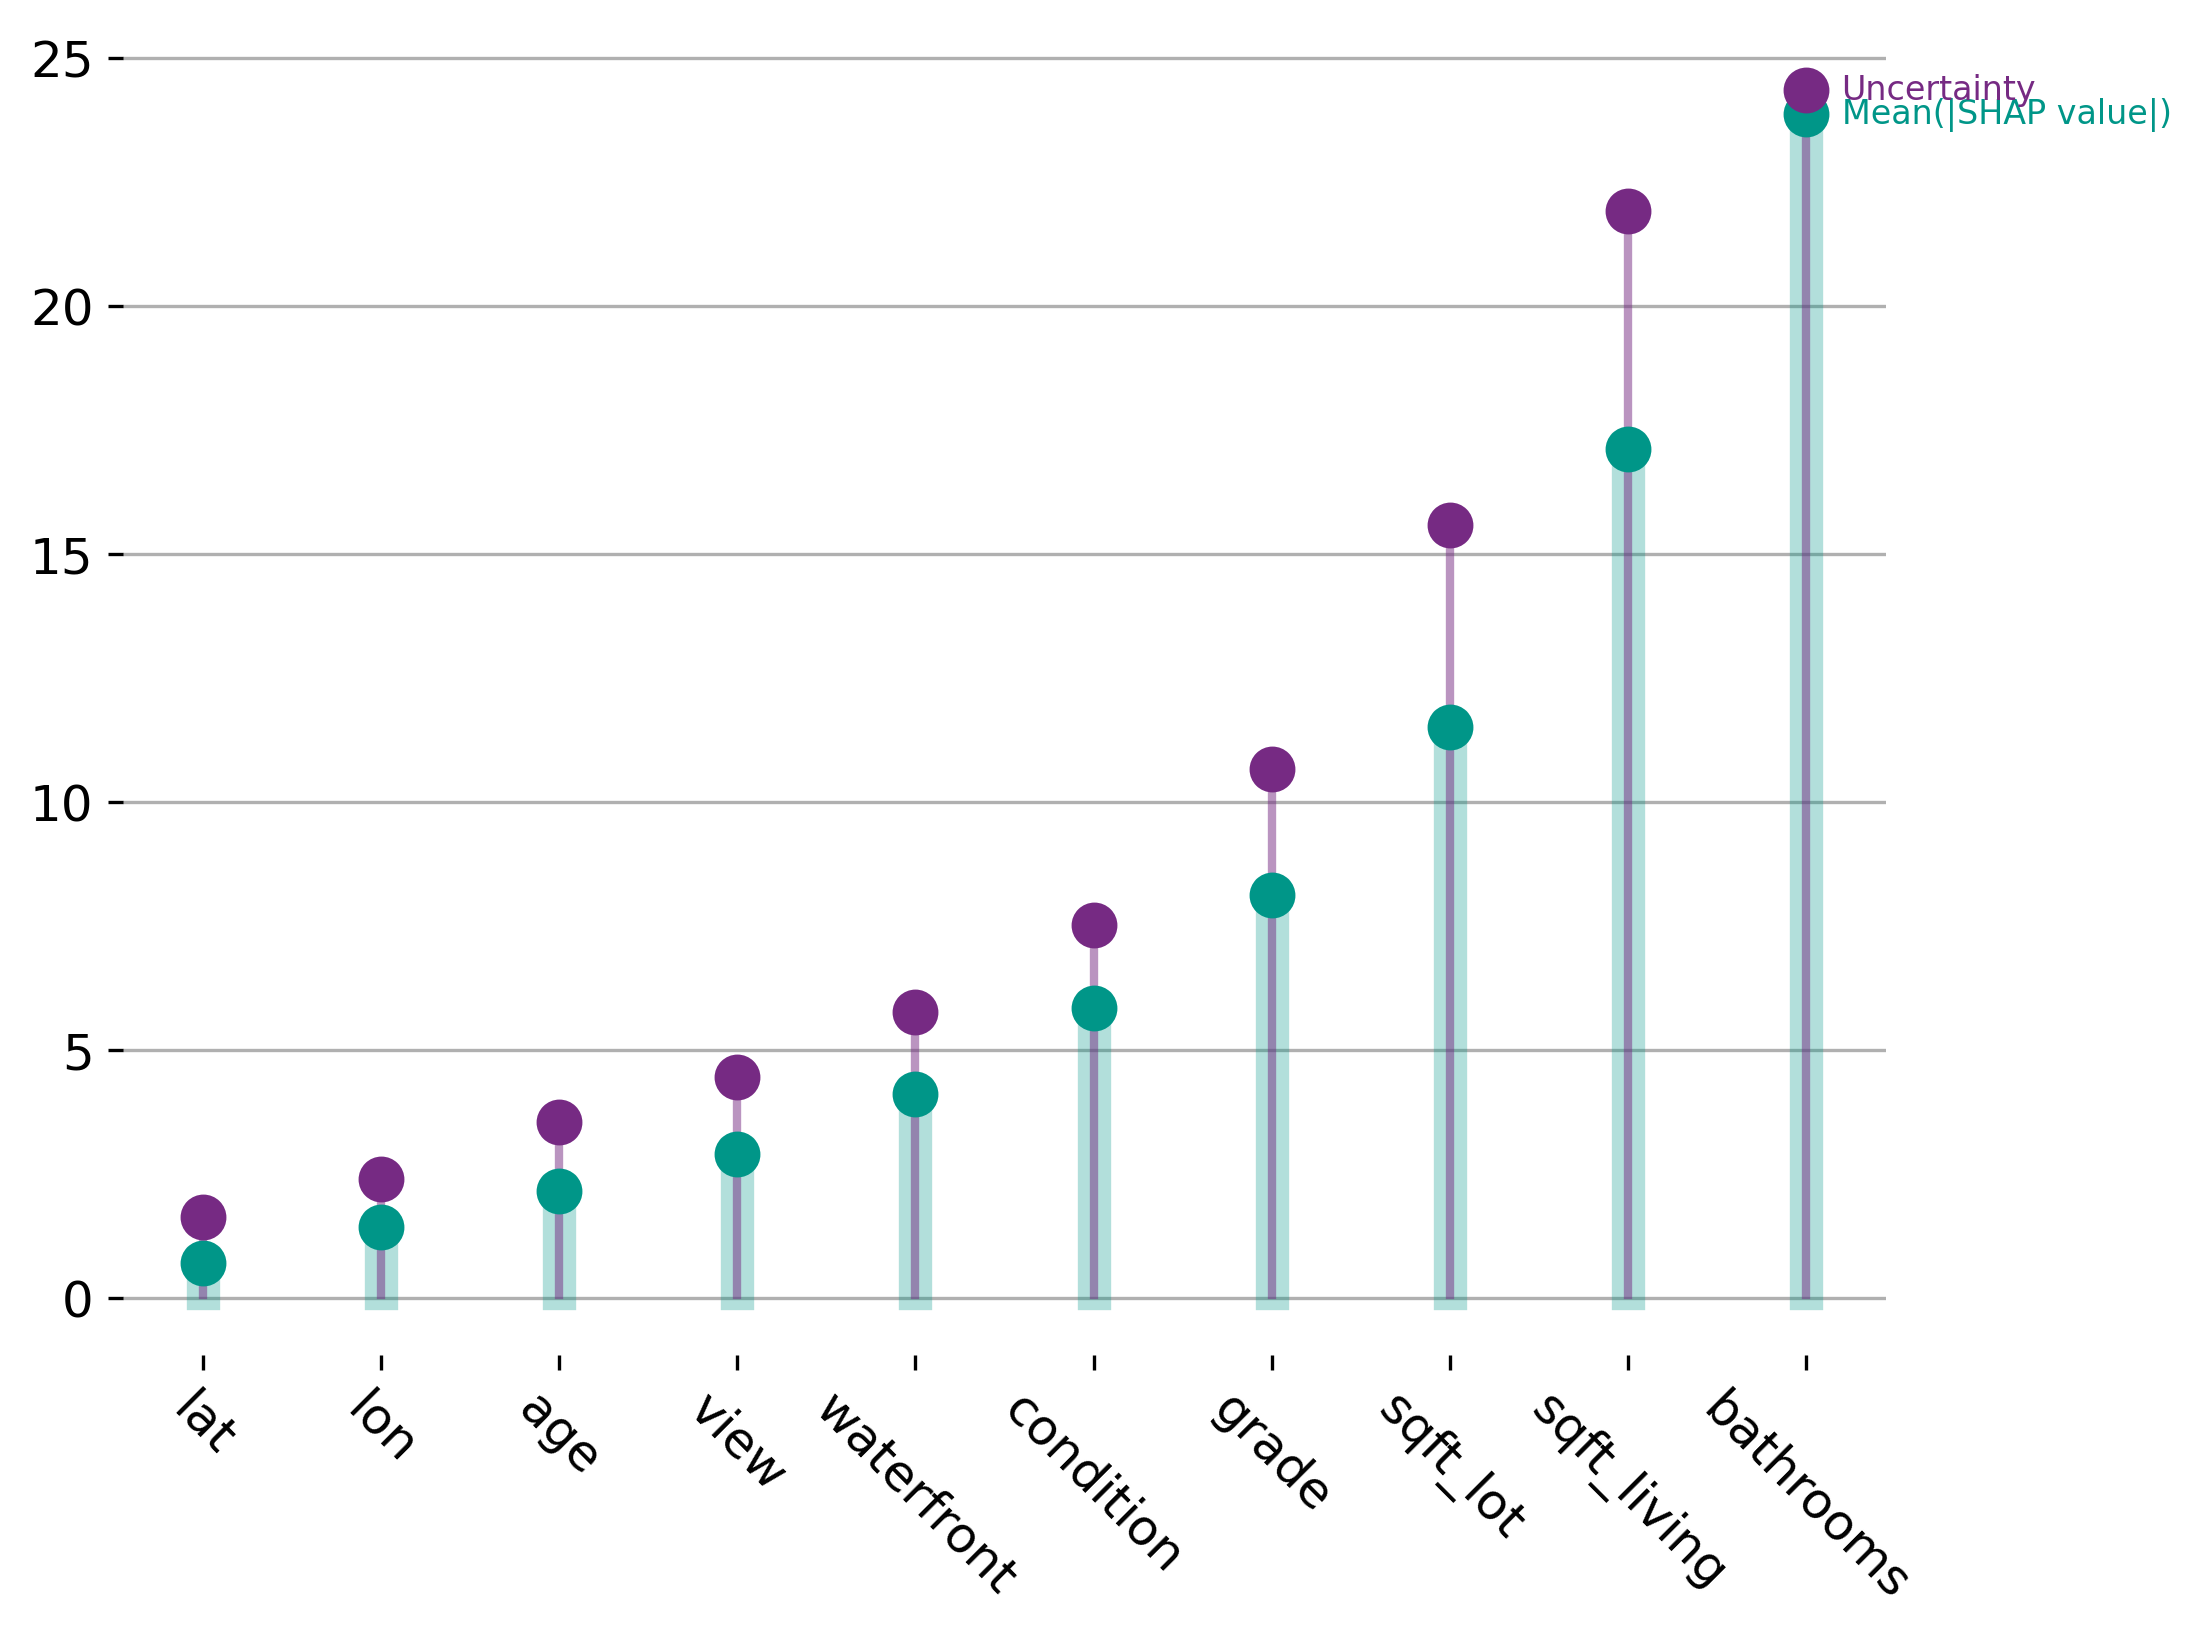

In [23]:
results.plot_absolute_shap_value_with_uncertainty(filename='SeattleHomeSale_absolute_shap_value_with_uncertainty_lime.png')

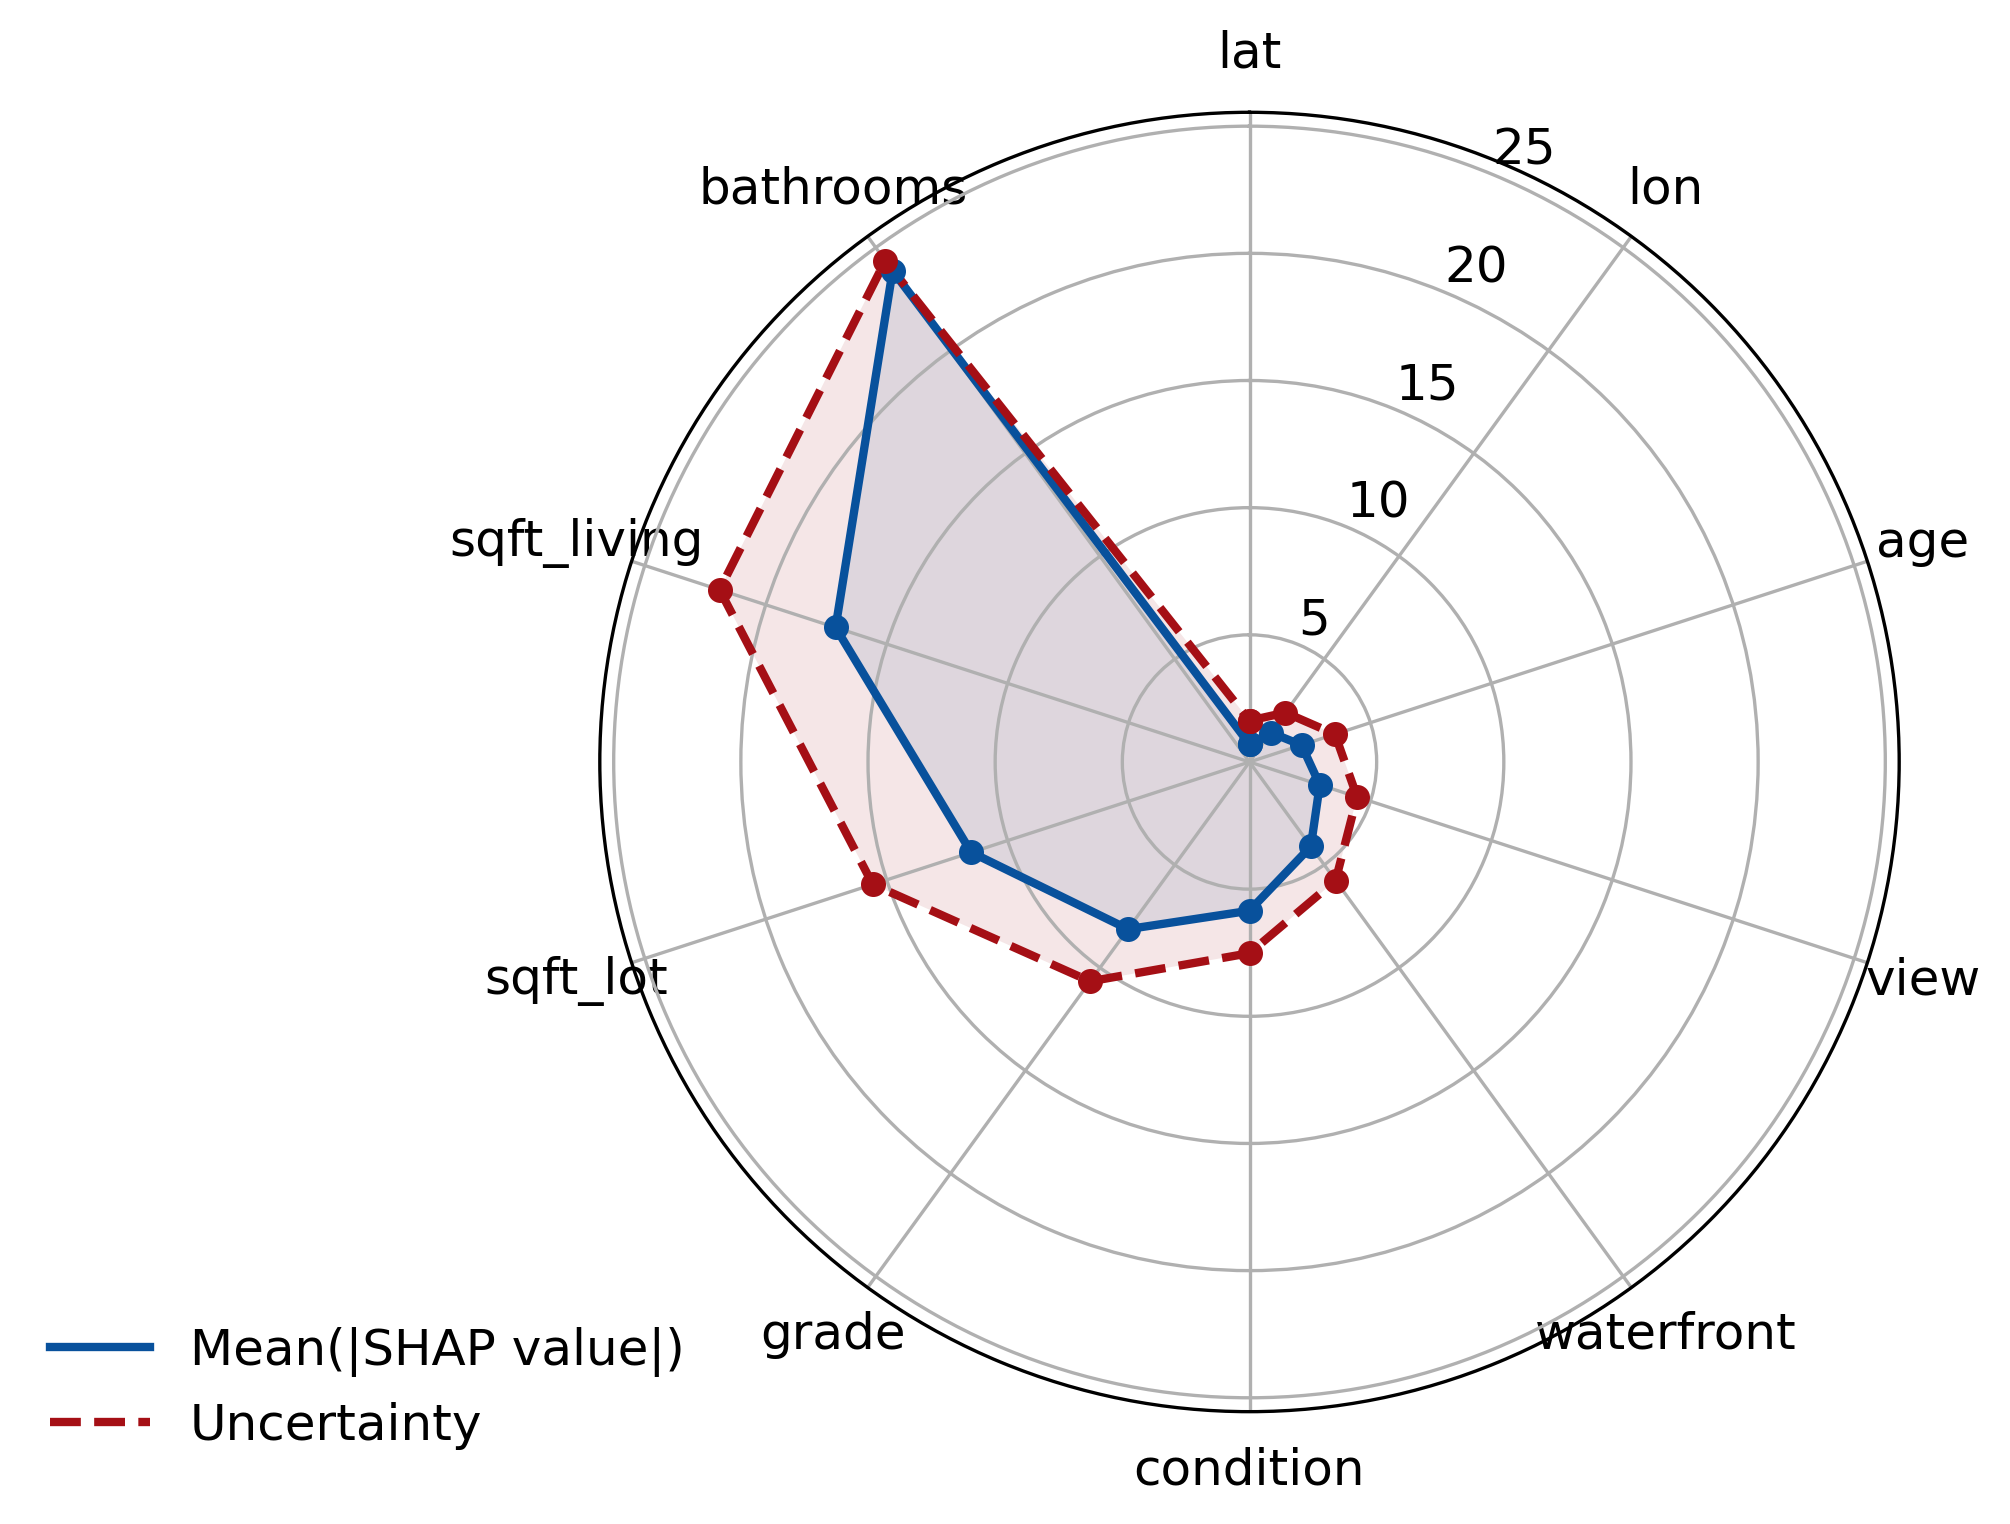

In [24]:
results.plot_absolute_shap_value_with_uncertainty_radar_chart(filename='SeattleHomeSale_absolute_shap_value_with_uncertainty_radar_lime.png')

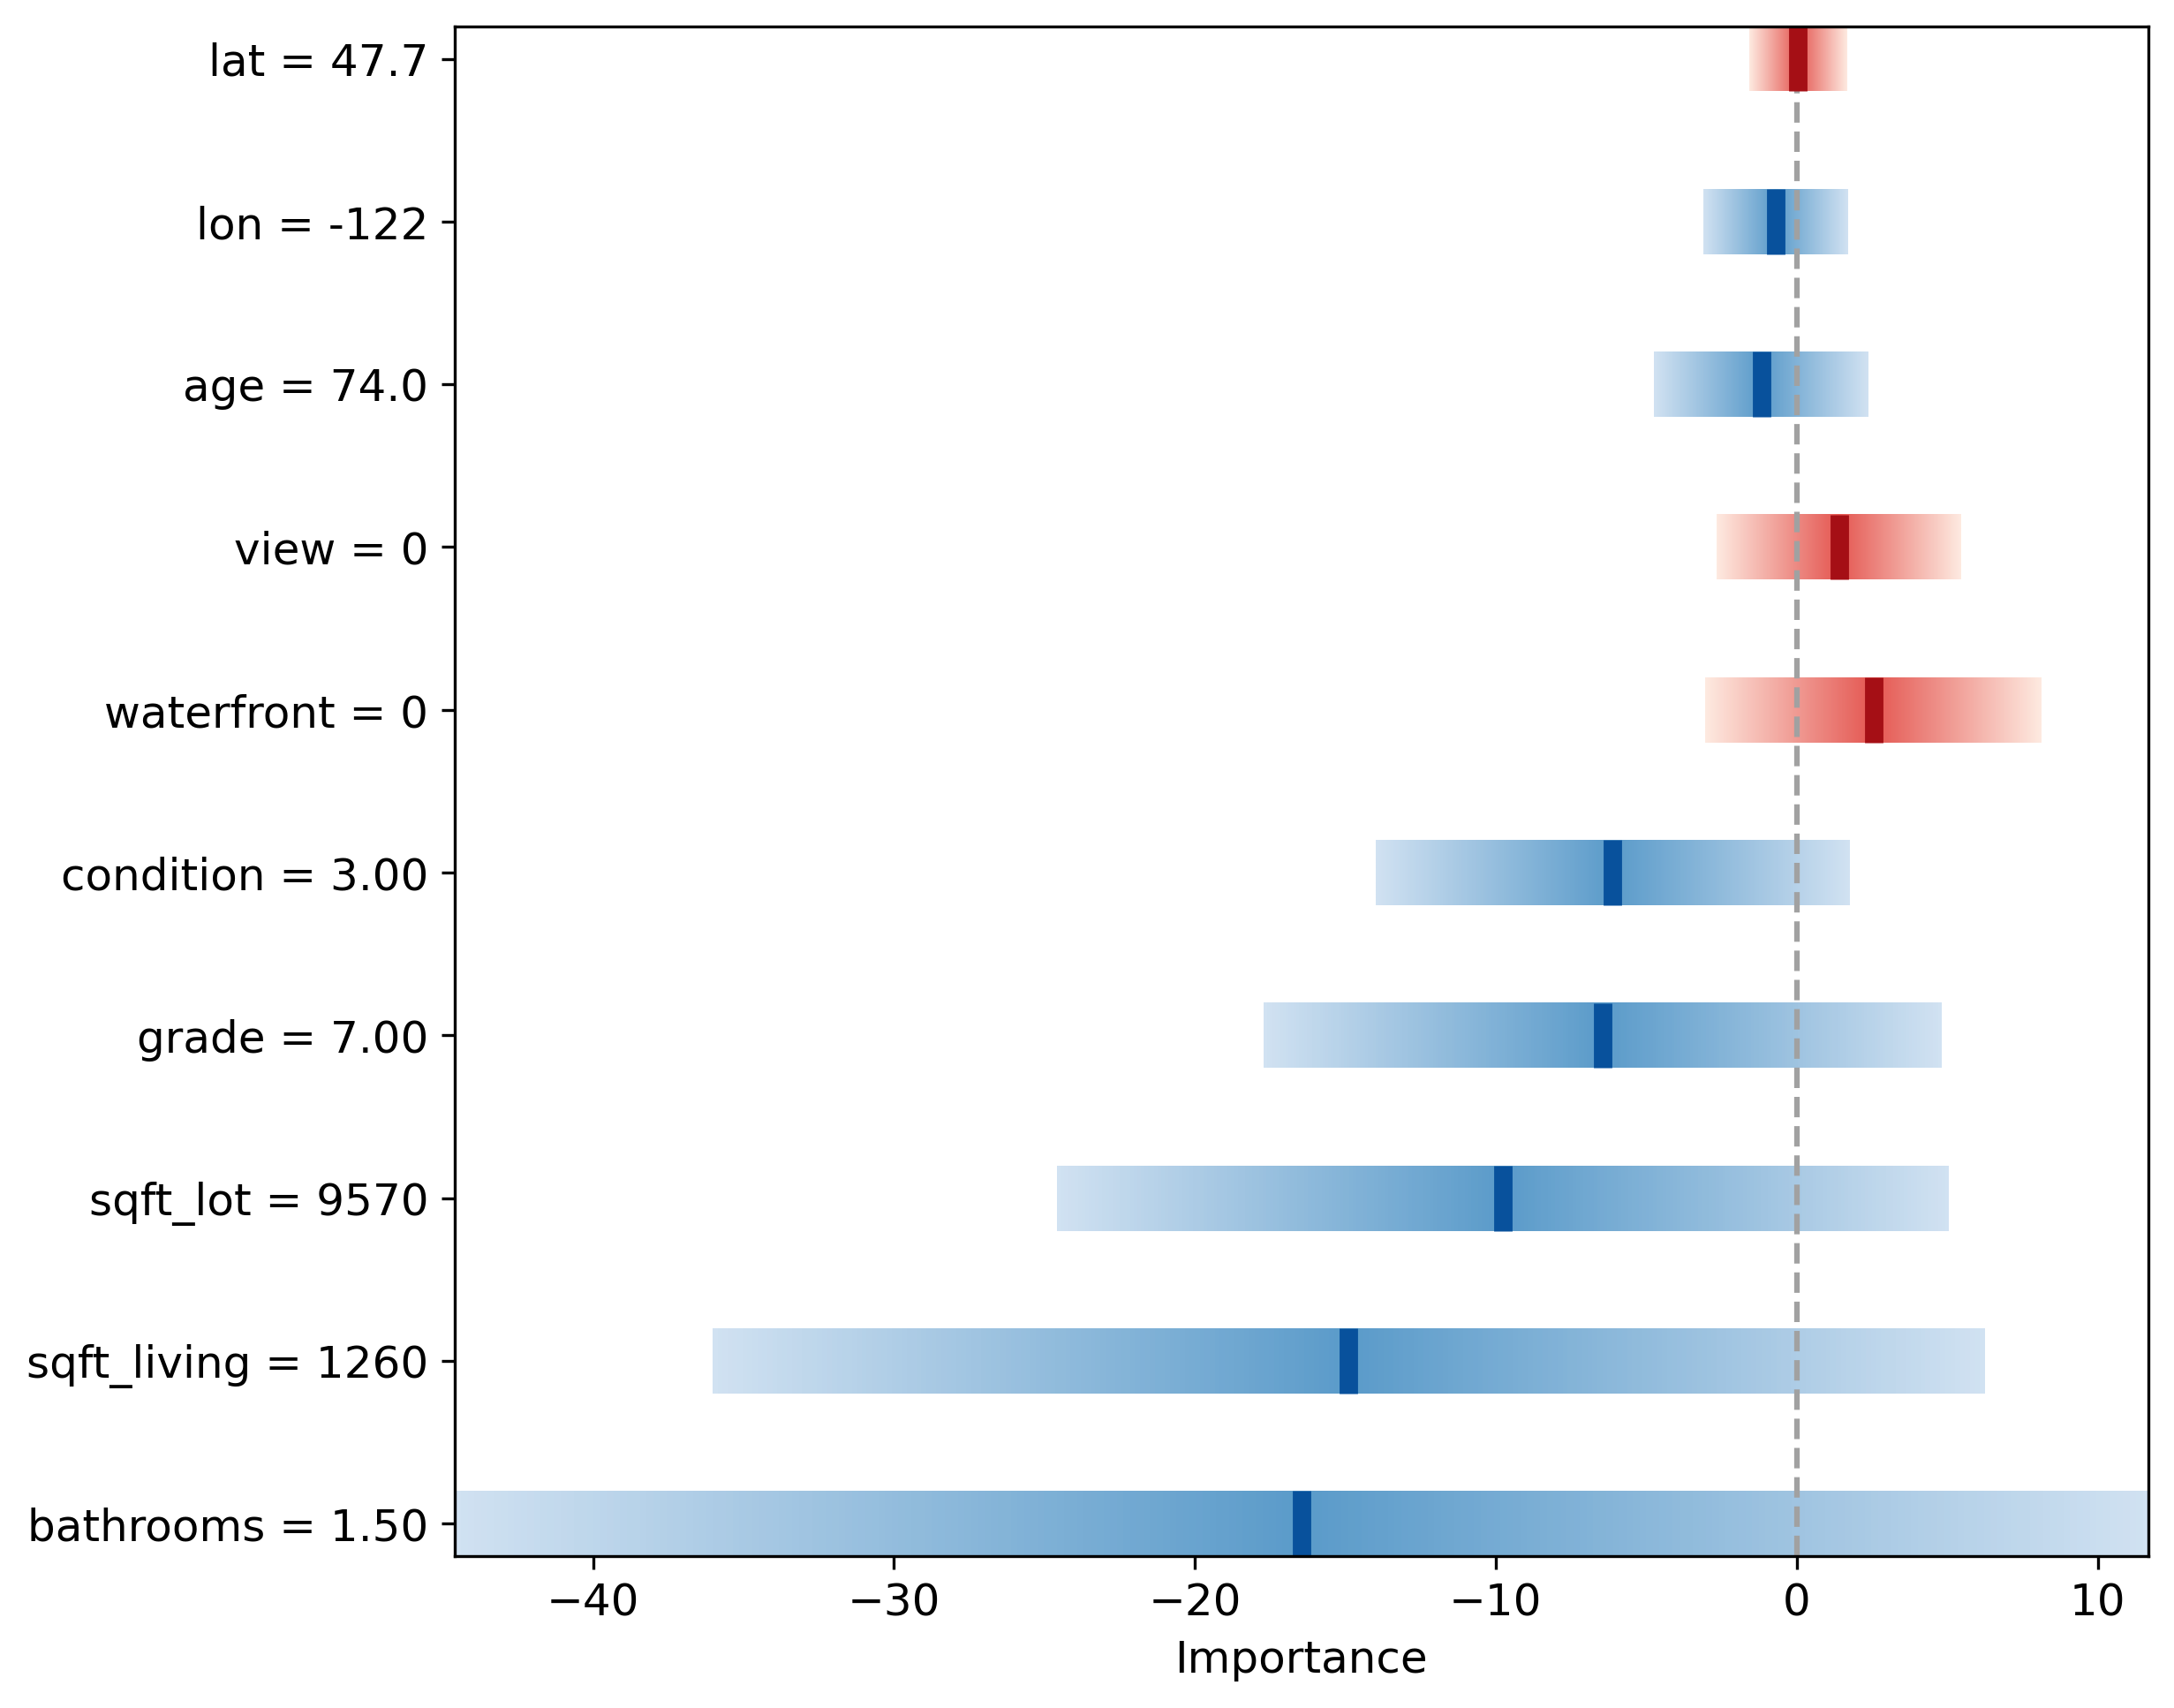

In [25]:
results.plot_shap_values_with_uncertainty(20, filename='SeattleHomeSale_shap_values_with_uncertainty_lime.png')

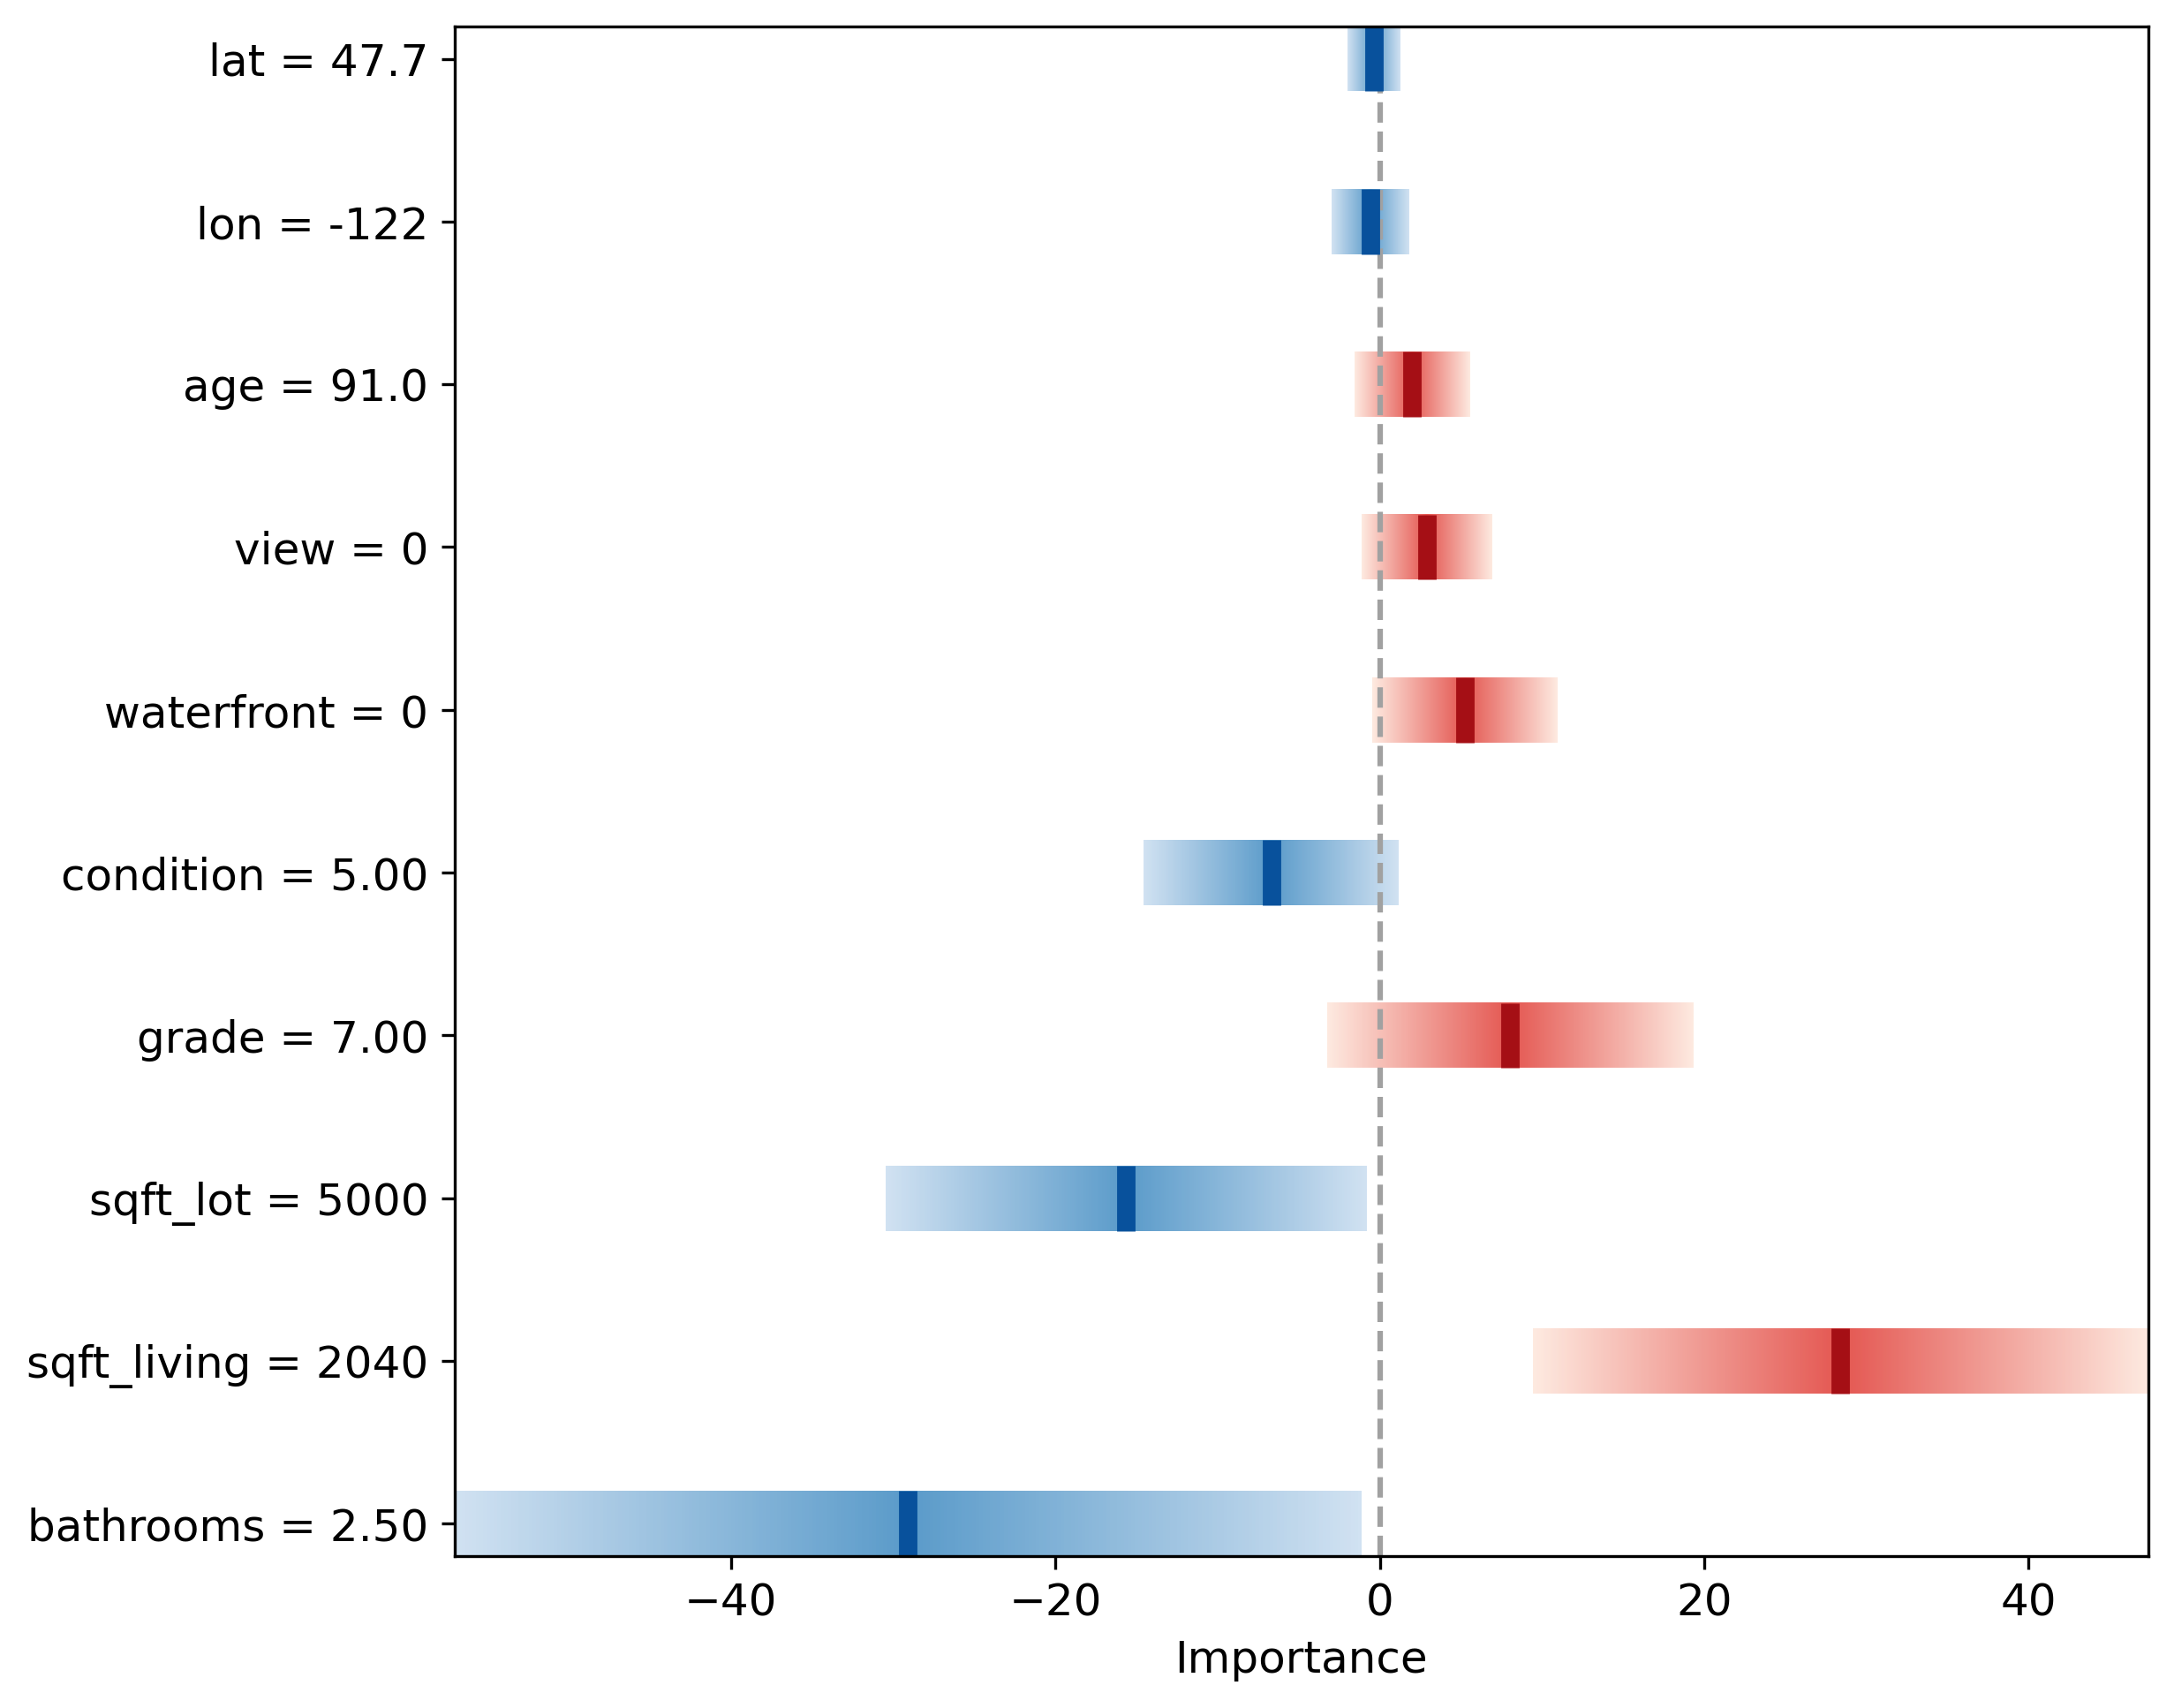

In [26]:
results.plot_shap_values_with_uncertainty(40)

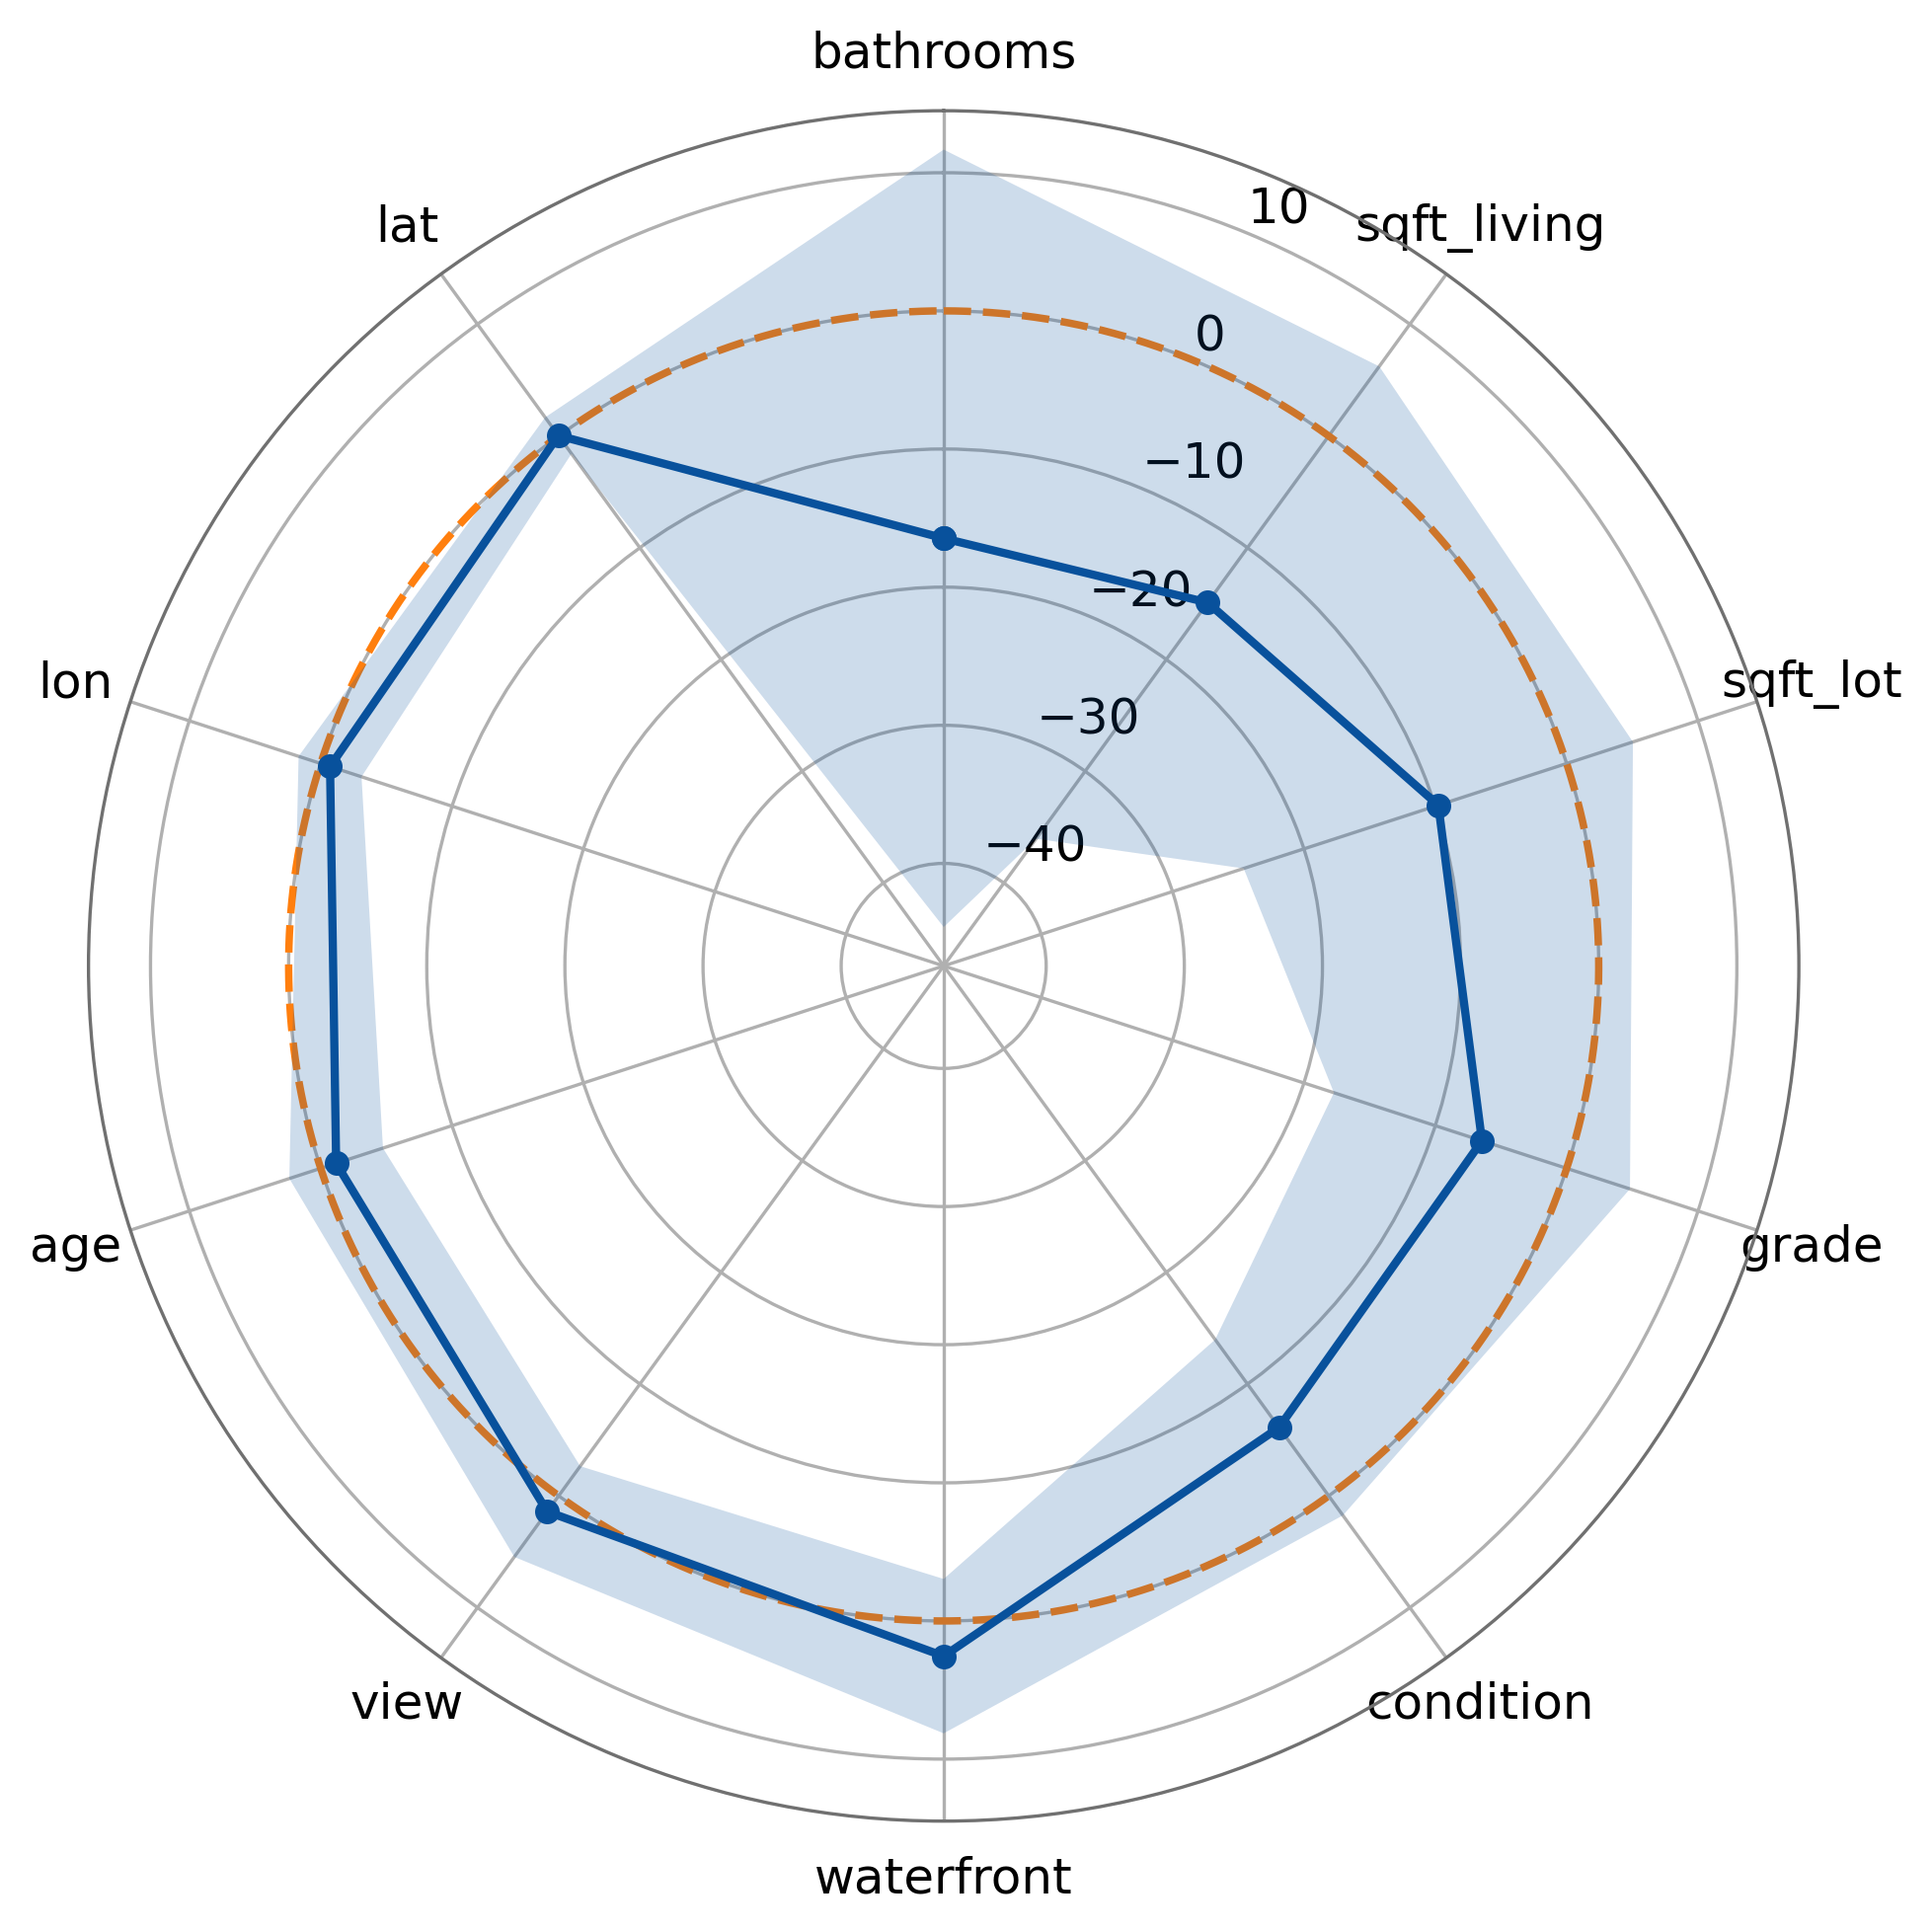

In [27]:
results.plot_shap_values_with_uncertainty_radar_chart(20, filename='SeattleHomeSale_shap_values_with_uncertainty_radar_lime.png')

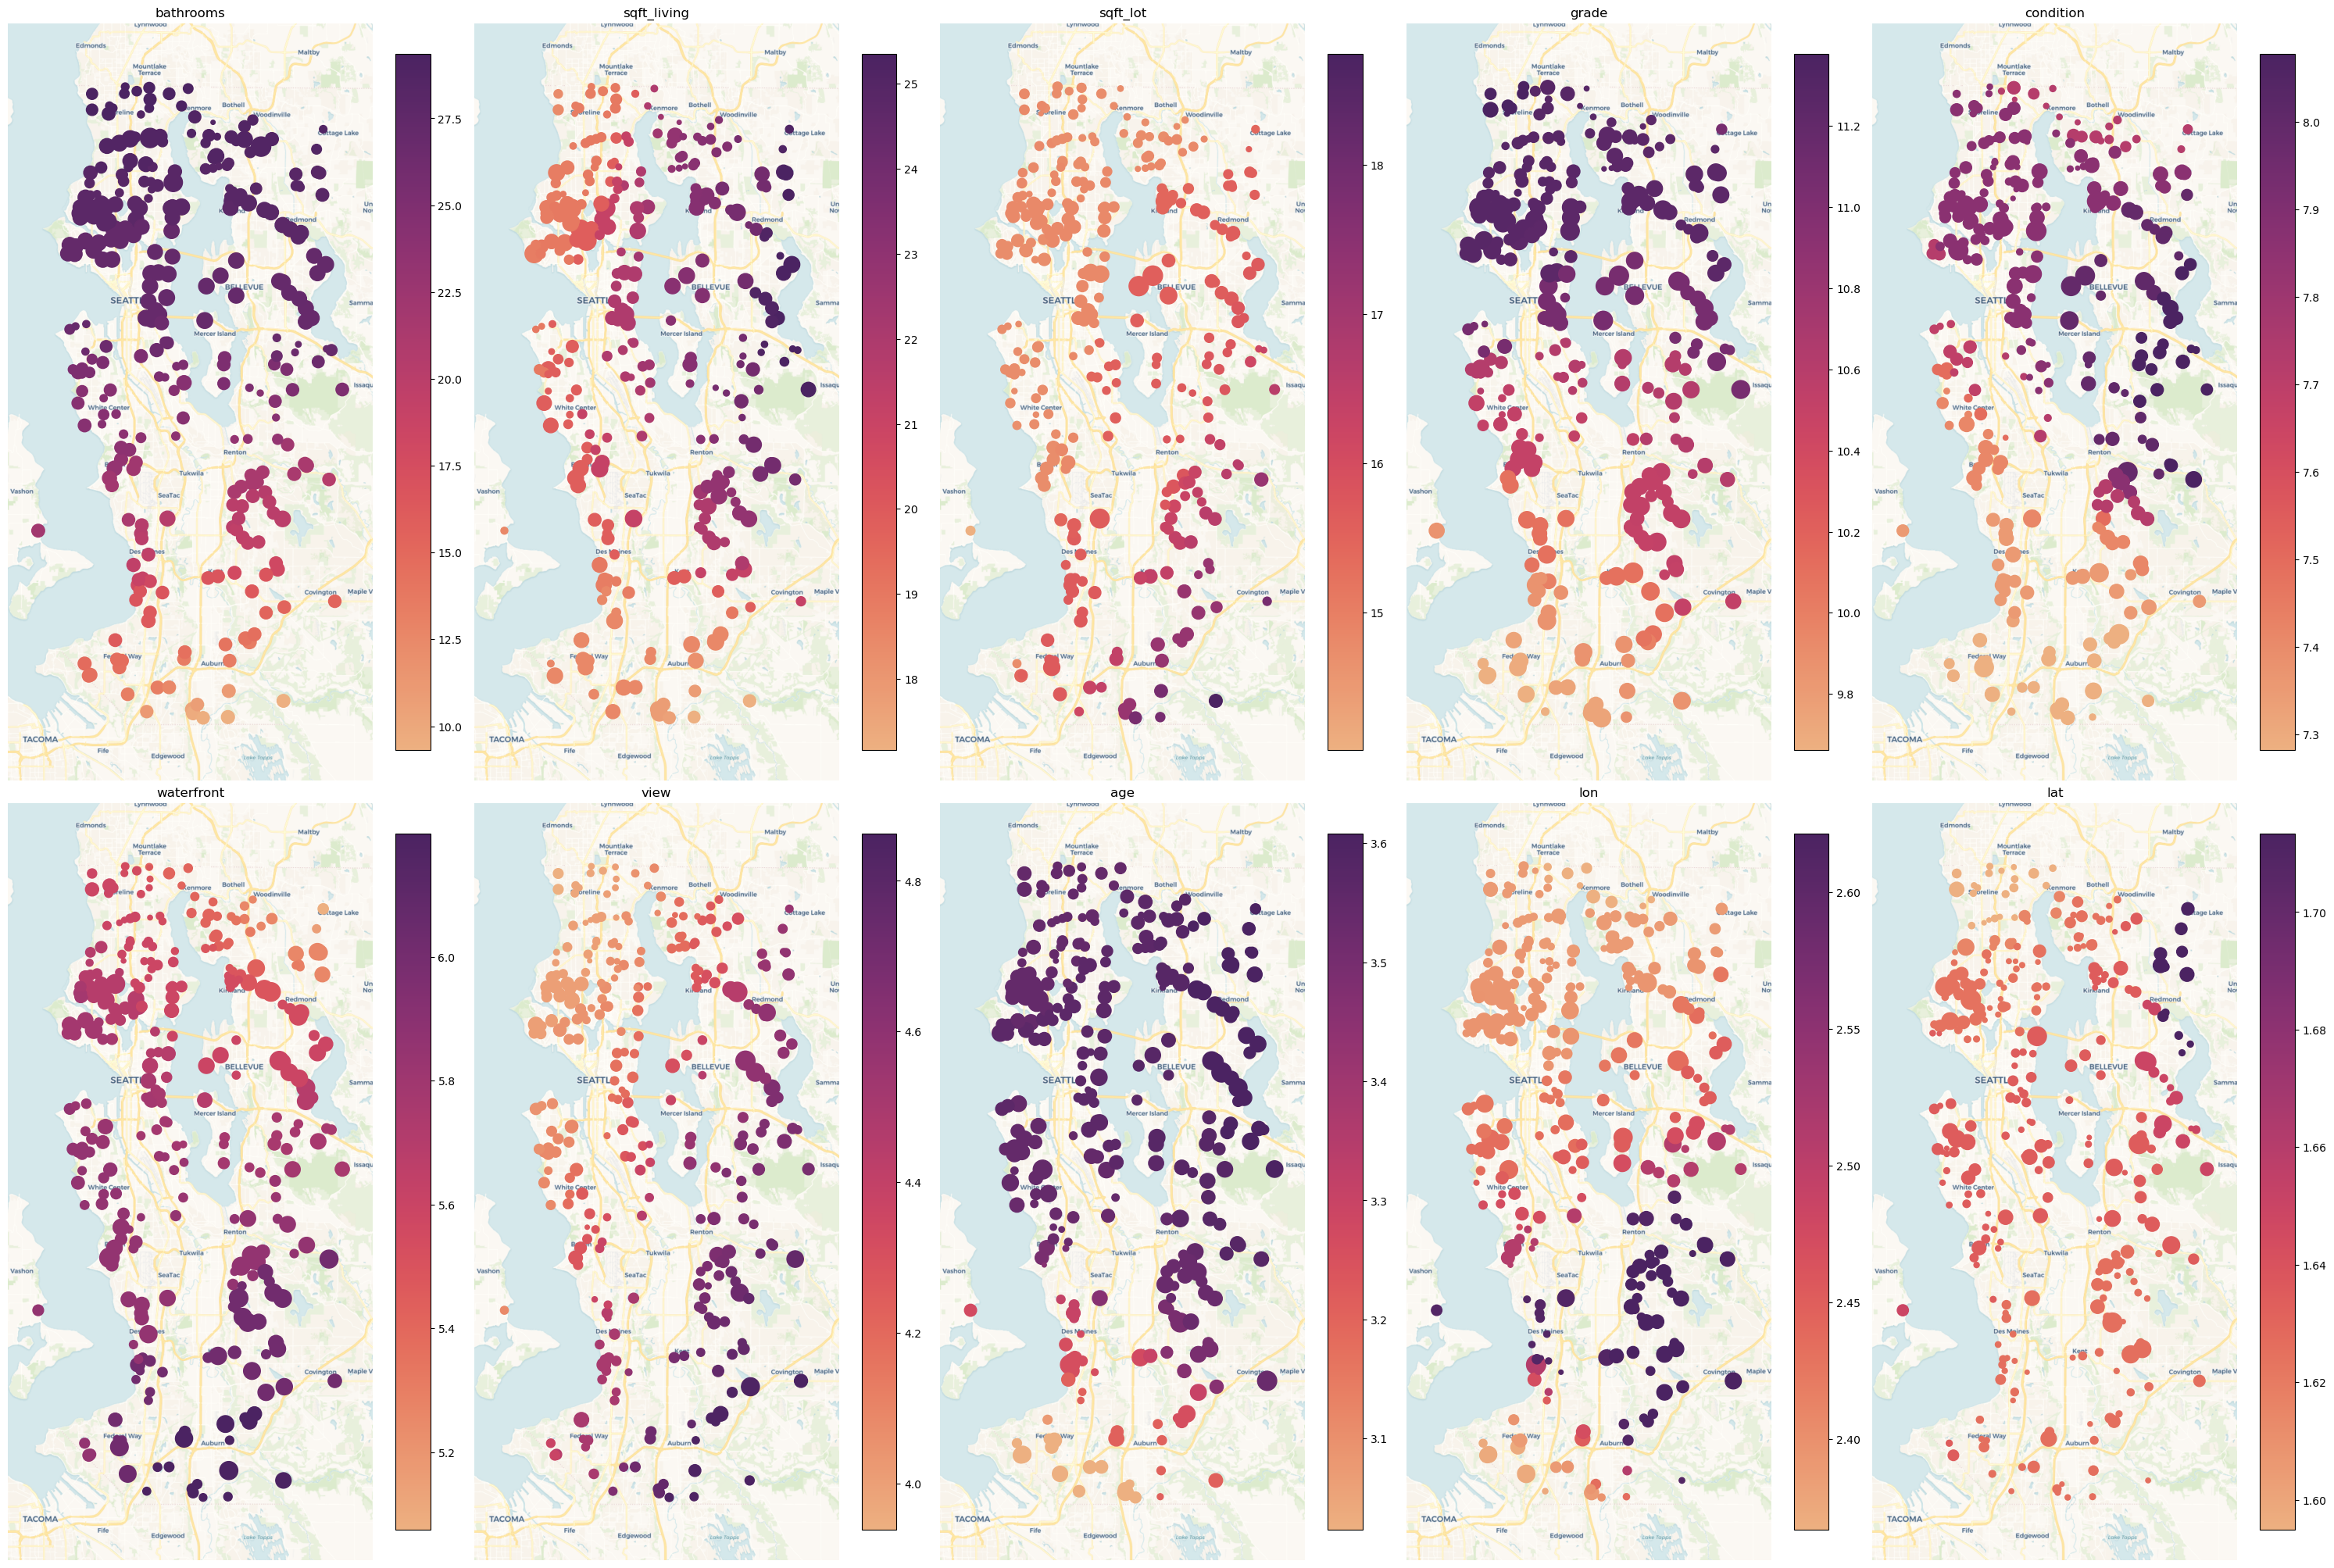

In [28]:
results.plot_geo_uncertainty(figsize=[30, 40], shrink=0.3, s_limits=(4, 18), cmap='flare', filename='SeattleHomeSale_geo_uncertainty_lime.png')